In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from train.metrics_f1 import calc_f1_score

In [2]:
path_train = r"./train/"

In [3]:
# данные по дислокации
dislok = pd.read_parquet(path_train + '/dislok_wagons.parquet').convert_dtypes()
# данные по текущим ремонтам
pr_rem = pd.read_parquet(path_train + '/pr_rems.parquet').convert_dtypes()
# список вагонов с остаточным пробегом на момент прогноза
wag_prob = pd.read_parquet(path_train + '/wagons_probeg_ownersip.parquet').convert_dtypes()
# параметры вагона
wag_param = pd.read_parquet(path_train + '/wag_params.parquet').convert_dtypes()
# таргет по прогноза выбытия вагонов в ПР на месяц и на 10 дней
target = pd.read_csv(path_train +'/target/y_train.csv').convert_dtypes()
# текущие ремонты вагонов
tr_rem = pd.read_parquet(path_train + '/tr_rems.parquet').convert_dtypes()

### Дислокация вагонов - обзор данных

In [4]:
dislok.columns

Index(['plan_date', 'wagnum', 'date_kap', 'date_dep', 'kod_vrab',
       'date_pl_rem', 'id_road_disl', 'st_id_dest', 'id_road_dest',
       'st_id_send', 'id_road_send', 'ost_prob', 'isload', 'fr_id',
       'last_fr_id', 'distance'],
      dtype='object')

In [5]:
dislok.describe()

,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance
count,6250933,6250933.0,3495902,5899060,6250933.0,6250933,6250933.0,6250933.0,6250933.0,6250933.0,6250933.0,5993618.0,6250933.0,6250933.0,6250933.0,6250933.0
mean,2022-10-31 11:55:08.225828,16987.724348,2017-06-28 07:10:14.700756,2020-05-30 03:53:28.155061,0.335888,2024-01-02 20:57:29.805650,28.120236,4430.1578,27.918747,7294.858465,27.915547,87927.205855,0.437835,1961.21203,1611.936678,560.194204
min,2022-08-01 00:00:00,0.0,2005-04-07 00:00:00,2013-07-20 00:00:00,0.0,2016-06-01 00:00:00,0.0,0.0,0.0,3.0,0.0,-48906.0,0.0,0.0,0.0,-1.0
25%,2022-09-15 00:00:00,8493.0,2014-09-28 00:00:00,2019-10-11 00:00:00,0.0,2023-05-21 00:00:00,16.0,22.0,16.0,4620.0,16.0,34627.0,0.0,1045.0,714.0,-1.0
50%,2022-10-31 00:00:00,16989.0,2019-06-13 00:00:00,2020-07-26 00:00:00,0.0,2023-11-22 00:00:00,29.0,4147.0,28.0,6996.0,28.0,78332.0,0.0,1671.0,1469.0,-1.0
75%,2022-12-16 00:00:00,25482.0,2020-10-04 00:00:00,2021-04-30 00:00:00,1.0,2024-07-28 00:00:00,38.0,8155.0,38.0,10368.0,38.0,130634.0,1.0,2255.0,1671.0,342.0
max,2023-01-31 00:00:00,33976.0,2022-08-14 00:00:00,2022-08-14 00:00:00,2.0,2026-12-14 00:00:00,45.0,16011.0,45.0,16011.0,45.0,500000.0,1.0,5073.0,5073.0,10387.0
std,NaN,9808.300516,NaN,NaN,0.490405,NaN,11.615489,4677.064409,11.898905,3531.344506,11.737802,71427.793599,0.49612,1208.423027,1237.496801,1268.892341


In [6]:
wagons = dislok.groupby('wagnum')[('plan_date')].agg(['min', 'max', 'count'])
display(wagons.head(5))
print(f"Всего {len(wagons[wagons['count'] != 184])} вагонов с неполными данными")

,min,max,count
wagnum,,,
0,2022-08-01,2023-01-31,184
1,2022-08-01,2023-01-31,184
2,2022-08-01,2023-01-31,184
3,2022-08-01,2023-01-31,184
4,2022-08-01,2023-01-31,184


Всего 30 вагонов с неполными данными


In [7]:
dislok.plan_date.unique()

<DatetimeArray>
['2022-08-01 00:00:00', '2022-08-02 00:00:00', '2022-08-03 00:00:00',
 '2022-08-04 00:00:00', '2022-08-05 00:00:00', '2022-08-06 00:00:00',
 '2022-08-07 00:00:00', '2022-08-08 00:00:00', '2022-08-09 00:00:00',
 '2022-08-10 00:00:00',
 ...
 '2023-01-22 00:00:00', '2023-01-23 00:00:00', '2023-01-24 00:00:00',
 '2023-01-25 00:00:00', '2023-01-26 00:00:00', '2023-01-27 00:00:00',
 '2023-01-28 00:00:00', '2023-01-29 00:00:00', '2023-01-30 00:00:00',
 '2023-01-31 00:00:00']
Length: 184, dtype: datetime64[us]

In [8]:
num_kap_rem = dislok.groupby('wagnum')['date_kap'].nunique()
num_kap_rem.value_counts()

date_kap
1    19450
0    14483
2       44
Name: count, dtype: int64

In [10]:
dislok.groupby('wagnum')['date_dep'].nunique().value_counts()

date_dep
1    30952
0     1853
2     1172
Name: count, dtype: int64

In [17]:
dislok['kod_vrab'].value_counts()

kod_vrab
0    4205795
1    1990661
2      54477
Name: count, dtype: Int64

In [20]:
dislok.groupby('wagnum')['date_pl_rem'].nunique().value_counts()

date_pl_rem
1    32232
2     1745
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

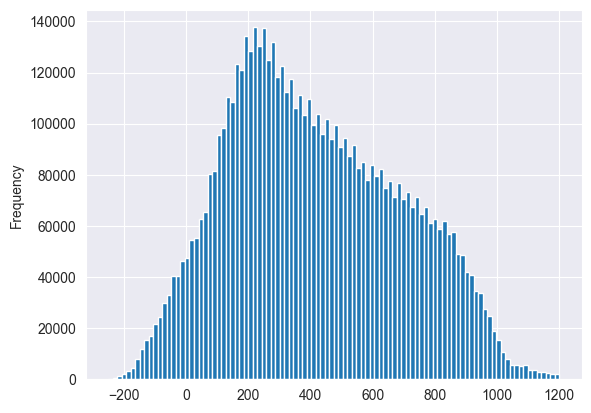

In [30]:
dislok['days_to_pl_rem'] = (dislok['date_pl_rem'] - dislok['plan_date']).dt.days
dislok['days_to_pl_rem'].plot.hist(bins=100, range=(-250, 1200))

In [34]:
dislok[dislok['days_to_pl_rem'] < 0].sample(5)

,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance,days_to_pl_rem,last_rem_date
861078,2022-12-04,31426,NaT,2019-08-23,0,2022-08-23,16,22,16,4421,16,146348,0,617,617,-1,-103,2019-08-23
302037,2022-12-29,11643,NaT,2019-06-17,1,2022-06-17,38,10375,38,10352,38,150409,1,721,721,-1,-195,2019-06-17
1008995,2022-09-06,33578,NaT,2021-08-30,0,2022-08-30,16,4789,28,4305,16,158951,1,988,988,-1,-7,2021-08-30
651434,2022-11-15,314,NaT,2019-10-31,1,2022-10-31,37,22,37,9019,37,156623,0,3689,3689,-1,-15,2019-10-31
895743,2023-01-20,4363,NaT,2019-11-30,0,2022-11-30,11,22,11,1725,11,154753,0,2255,1023,52,-51,2019-11-30


<Axes: ylabel='Frequency'>

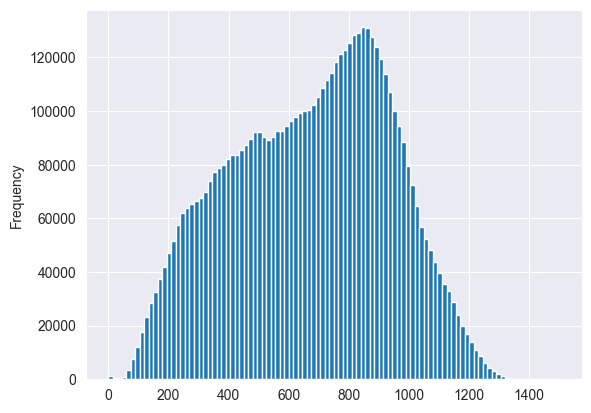

In [41]:
dislok['last_rem_date'] = dislok[['date_kap', 'date_dep']].max(axis=1)
dislok['days_from_last_rem'] = (dislok['plan_date'] - dislok['last_rem_date']).dt.days
dislok['days_from_last_rem'].plot.hist(bins=100, range=(0, 1500))

,min,max,mean,median,std
wagnum,,,,,
23611,524,707,615.500000,615.5,53.260367
28593,136,319,227.500000,227.5,53.260367
30438,-6,1096,95.619565,85.5,117.533517
20595,329,512,420.500000,420.5,53.260367
6490,-3,180,88.500000,88.5,53.260367


<Axes: >

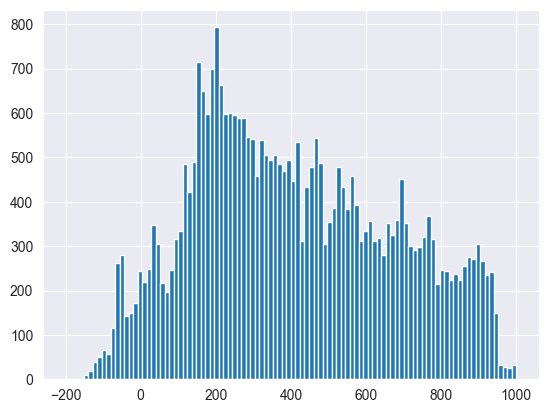

In [47]:
days_to_pl_rem = dislok.groupby('wagnum')['days_to_pl_rem'].agg(['min', 'max', 'mean', 'median', 'std'])
display(days_to_pl_rem.sample(5))
days_to_pl_rem['mean'].hist(bins=100, range=(-200, 1000))

In [49]:
dislok['id_road_disl'].value_counts()

id_road_disl
28    824214
16    564774
38    548539
25    523266
36    482840
3     373329
11    368007
42    352689
44    323956
30    306991
31    267093
15    253313
37    251937
29    231231
40    224546
43    192589
10     36622
33     35386
0      23202
26     17635
35     14911
41      9465
39      5896
8       4583
32      4149
27      3858
34      3229
7       1629
9        610
20       184
1        181
45        79
Name: count, dtype: Int64

In [51]:
dislok['st_id_dest'].nunique()

2448

In [52]:
dislok['st_id_send'].nunique()

2559

In [53]:
dislok['another_road'] = dislok['id_road_dest'] != dislok['id_road_send']
dislok['another_road'].value_counts()

another_road
True     3261068
False    2989865
Name: count, dtype: Int64

In [56]:
dislok['distance'].value_counts()

distance
-1      4430643
1188       1225
1153       1224
1156       1223
1189       1218
         ...   
8565          1
8623          1
8618          1
9277          1
7806          1
Name: count, Length: 9482, dtype: Int64

In [57]:
dislok[dislok['distance'] == -1].sample(5)

,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance,days_to_pl_rem,last_rem_date,days_from_last_rem,another_road
183289,2023-01-30,19864,NaT,2021-10-22,1,2024-10-22,44,12331,44,7235,30,79128,1,1395,1395,-1,631,2021-10-22,465.0,True
1038054,2022-08-20,33569,NaT,2021-09-07,0,2022-09-07,25,22,25,5310,25,<NA>,0,1660,1660,-1,18,2021-09-07,347.0,False
448046,2023-01-16,26304,2013-11-14,2020-02-12,0,2023-02-12,43,12393,44,10334,38,137451,1,727,727,-1,27,2020-02-12,1069.0,True
4769,2022-11-30,11621,NaT,2021-03-23,1,2024-03-23,40,10407,38,12346,44,69373,1,4164,4164,-1,479,2021-03-23,617.0,True
575666,2023-01-09,26276,2013-08-13,2020-02-01,0,2023-02-01,16,4420,16,385,3,153866,1,617,617,-1,23,2020-02-01,1073.0,True


<Axes: ylabel='Frequency'>

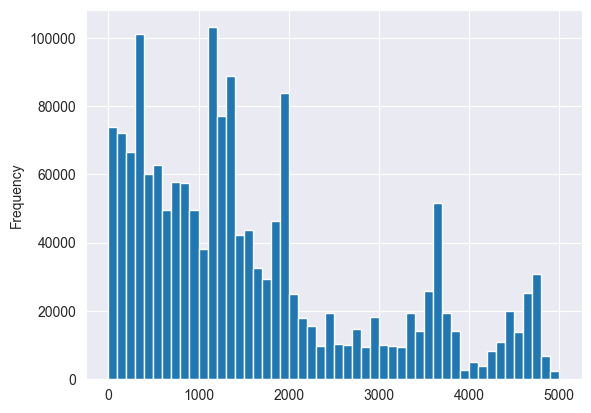

In [63]:
dislok['distance'].plot.hist(bins=50, range=(0, 5000))

<Axes: ylabel='Frequency'>

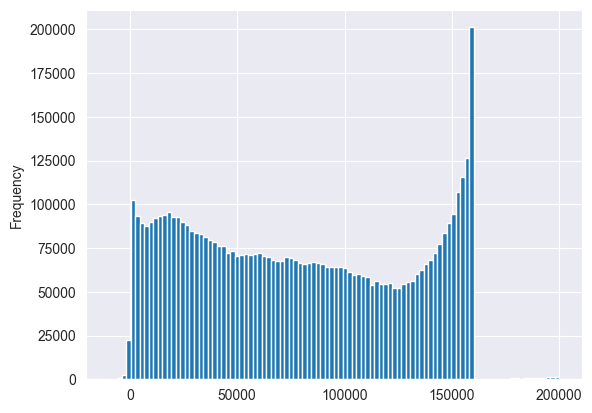

In [74]:
dislok['ost_prob'].plot.hist(bins=100, range=(-10000, 200000))

In [76]:
dislok['isload'].value_counts()

isload
0    3514058
1    2736875
Name: count, dtype: Int64

In [77]:
dislok['fr_id'].value_counts()

fr_id
2255    2043447
5032     294975
714      258681
1671     214575
1660     201142
         ...   
1915          1
2254          1
3499          1
3354          1
3278          1
Name: count, Length: 921, dtype: Int64